In [108]:
!pip install selenium
!pip install vaderSentiment

In [133]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options
# https://github.com/cjhutto/vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import scipy

In [110]:
options = Options()
options.add_argument('--no-sandbox')
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--disable-blink-features=AutomationControlled')


driver = webdriver.Chrome(options=options)

In [115]:
driver.get('https://www.cbc.ca/news/opinion')
 # Click on the element
driver.implicitly_wait(2)
try:
  driver.find_element(By.CLASS_NAME, "noticeButton").click()
except:
  print("there is no notice button blocking the way")

#try to fetch all the available opinion article
for x in range(10):
  driver.implicitly_wait(2)
  try:
    driver.find_element(By.CLASS_NAME, "loadMore").click()
  except:
    print("you may have exhausted the list")

there is no notice button blocking the way
you may have exhausted the list
you may have exhausted the list
you may have exhausted the list
you may have exhausted the list
you may have exhausted the list
you may have exhausted the list


In [116]:
# store data inside the pandas dataframe
time_element = driver.find_elements(By.XPATH, '//time[@class="timeStamp"]')
df = pd.DataFrame({'time': [x.text for x in time_element]
                   , 'datetime': pd.to_datetime([x.get_attribute("datetime") for x in time_element])
                   , 'title': [x.text for x in driver.find_elements(By.XPATH, '//h3[@class="headline"]')]})
# for element in driver.find_elements(By.XPATH, '//time[@class="timeStamp"]'):
#   print(element.get_attribute("datetime"))
# for element in driver.find_elements(By.XPATH, '//h3[@class="headline"]'):
#   print(element.text)


In [117]:
# use sentiment analysis tool
analyzer = SentimentIntensityAnalyzer()
sentiment_data = []
for title in list(df['title']):
    vs = analyzer.polarity_scores(title)
    # print("{:-<65} {}".format(title, str(vs)))
    sentiment_data.append(vs["compound"])
df['sentiment'] = sentiment_data

R-sqaured is 0.0057


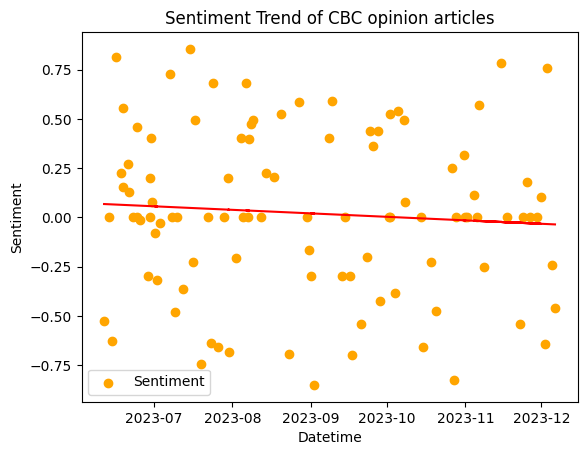

In [140]:
# Plotting the scatter plot
plt.scatter(df['datetime'], df['sentiment'], color='orange', label='Sentiment')

# Customize the plot
plt.xlabel('Datetime')
plt.ylabel('Sentiment')
plt.title('Sentiment Trend of CBC opinion articles')
plt.legend()

# Add the line of best fit
X = mdates.date2num(list(df['datetime']))
y = df['sentiment']
theta = np.polyfit(X, y, 1)
y_line = theta[1] + theta[0] * X
plt.plot(X, y_line, 'r')

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, y)
print('R-sqaured is {:.4f}'.format(r_value**2))

# Show the plot
plt.show()

Ratio between postive and negative sentiment is 1.1464


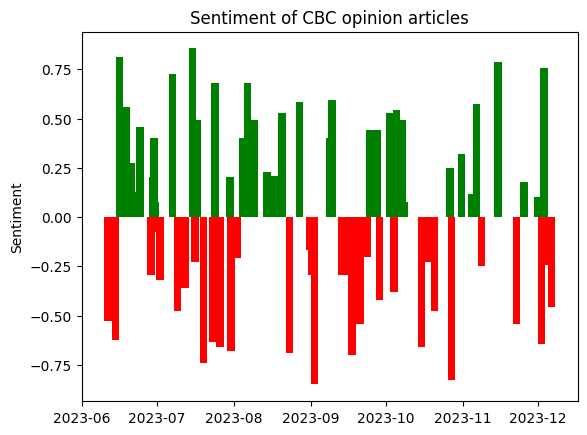

In [184]:
fig, ax = plt.subplots()

# positive sentiment: compound score >= 0.05
# neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
# negative sentiment: compound score <= -0.05
bar_labels = ['positive' if e >= 0.05 else 'negative' if e <= -0.05 else 'neutral' for e in list(df['sentiment'])]
bar_colors = ['g' if e >= 0.05 else 'r' if e <= -0.05 else 'w' for e in list(df['sentiment'])]
r = ax.bar(df['datetime'], df['sentiment'], label=bar_labels, color=bar_colors, width=3)

ax.set_ylabel('Sentiment')
ax.set_title('Sentiment of CBC opinion articles')

ratio = df.query("sentiment >= 0.05")['sentiment'].sum() / -df.query("sentiment <= -0.05")['sentiment'].sum()
print('Ratio between postive and negative sentiment is {:.4f}'.format(ratio))
plt.show()

In [120]:
driver.quit()

In [ ]:
# Conclusion: It is found that since June 2023, the sentiment of CBC opinion has been fairly neutral as seen in the scatter plot.
# But if we aggregate the compund sentiment, there is more positive than negative.